In [32]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import Libraries

In [33]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import shap

import sys
import os


In [34]:
path = '../data/cleaned_insurance_data.csv'

sys.path.append(os.path.abspath('../scripts/'))

from load_data import load_csv

In [35]:
df = load_csv(path)

c:\Users\Tegbabu\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\scripts\load_data.py:45: DtypeWarning: Columns (31) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(filepath)
2025-06-19 03:25:48,165 - INFO - CSV file loaded successfully from ../data/cleaned_insurance_data.csv.


In [36]:
#pd.set_option('display.max_columns', None)
df = df.sample(n=50000, random_state=42)

In [37]:
df.head()

,UnderwrittenCoverID,PolicyID,TransactionMonth,IsVATRegistered,Citizenship,LegalType,Title,Language,Bank,AccountType,...,ExcessSelected,CoverCategory,CoverType,CoverGroup,Section,Product,StatutoryClass,StatutoryRiskType,TotalPremium,TotalClaims
251986,168327,14084,2015-04-01,False,,Individual,Mr,English,Capitec Bank,Savings account,...,Mobility - Taxi with value more than R100 000 ...,Own Damage,Own Damage,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,0.000000,0.0
158758,142917,12434,2015-08-01,False,,Individual,Mr,English,ABSA Bank,Savings account,...,No excess,Signage and Vehicle Wraps,Signage and Vehicle Wraps,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,2.320439,0.0
219262,110219,7699,2015-02-01,False,,Individual,Mr,English,Capitec Bank,Savings account,...,No excess,Passenger Liability,Passenger Liability,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,1.083421,0.0
561053,49344,4082,2015-03-01,False,,Individual,Mr,English,Unknown,Current account,...,No excess,Cleaning and Removal of Accident Debris,Cleaning and Removal of Accident Debris,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,5.994386,0.0
403321,108618,8322,2015-01-01,False,,Individual,Mr,English,Nedbank,Current account,...,Mobility - Windscreen,Windscreen,Windscreen,Comprehensive - Taxi,Motor Comprehensive,Mobility Commercial Cover: Monthly,Commercial,IFRS Constant,0.000000,0.0


#### Data Preparation

In [38]:
# Identify columns based on your provided Dtypes
date_object_columns = ['TransactionMonth', 'VehicleIntroDate'] # These are 'object' but are dates
bool_column = 'IsVATRegistered' # This is 'bool' and can be directly used or converted to int
int_columns = ['UnderwrittenCoverID', 'PolicyID', 'PostalCode', 'RegistrationYear']
float_columns = ['mmcode', 'Cylinders', 'cubiccapacity', 'kilowatts', 'NumberOfDoors',
                 'SumInsured', 'CalculatedPremiumPerTerm', 'TotalPremium', 'TotalClaims']
object_categorical_columns = [
    'Citizenship', 'LegalType', 'Title', 'Language', 'Bank', 'AccountType',
    'MaritalStatus', 'Gender', 'Country', 'Province', 'MainCrestaZone',
    'SubCrestaZone', 'ItemType', 'VehicleType', 'make', 'Model', 'bodytype',
    'AlarmImmobiliser', 'TrackingDevice', 'TermFrequency', 'ExcessSelected',
    'CoverCategory', 'CoverType', 'CoverGroup', 'Section', 'Product',
    'StatutoryClass', 'StatutoryRiskType'
]

In [39]:
# --- 1. Handle Special Numerical-like Object Columns ---

# CapitalOutstanding: Remove commas and convert to numeric
capital_outstanding_col = 'CapitalOutstanding'
if capital_outstanding_col in df.columns:
    # Convert to string first to handle potential NaNs (which would be float) before .replace()
    df[capital_outstanding_col] = df[capital_outstanding_col].astype(str).str.replace(',', '', regex=False)
    df[capital_outstanding_col] = pd.to_numeric(df[capital_outstanding_col], errors='coerce')
    # Impute NaNs after conversion
    imputer_num = SimpleImputer(strategy='median')
    if df[capital_outstanding_col].isnull().any():
        df[capital_outstanding_col] = imputer_num.fit_transform(df[[capital_outstanding_col]]).flatten()


In [ ]:
# --- 2. Handle Date/Time Columns (TransactionMonth, VehicleIntroDate) ---
date_object_columns = ['TransactionMonth', 'VehicleIntroDate']

for col in date_object_columns:
    if col in df.columns:
        # Convert to datetime, coercing errors will turn unparseable dates into NaT
        df[col] = pd.to_datetime(df[col], errors='coerce')

        # Using a consistent 'as_of_date' like current date for duration calculations
        as_of_date = pd.to_datetime('2025-06-19') # Using today's date based on current context

        df[f'{col}_Year'] = df[col].dt.year
        df[f'{col}_Month'] = df[col].dt.month
        df[f'{col}_Day'] = df[col].dt.day
        df[f'{col}_DayOfWeek'] = df[col].dt.dayofweek
        df[f'{col}_DayOfYear'] = df[col].dt.dayofyear
        df[f'{col}_Quarter'] = df[col].dt.quarter
        df[f'{col}_Age_Years'] = (as_of_date.year - df[col].dt.year).astype(float) # Age in years

        # Impute NaNs for newly created numerical date features
        temp_imputer = SimpleImputer(strategy='median')
        for new_date_feature in [f'{col}_Year', f'{col}_Month', f'{col}_Day',
                                 f'{col}_DayOfWeek', f'{col}_DayOfYear', f'{col}_Quarter', f'{col}_Age_Years']:
            if df[new_date_feature].isnull().any():
                df[new_date_feature] = temp_imputer.fit_transform(df[[new_date_feature]]).flatten()
            # Convert to int where appropriate (year, month, day, quarter, dayofweek, dayofyear)
            if new_date_feature in [f'{col}_Year', f'{col}_Month', f'{col}_Day',
                                 f'{col}_DayOfWeek', f'{col}_DayOfYear', f'{col}_Quarter']:
                df[new_date_feature] = df[new_date_feature].astype(int)


        # Drop the original date column after feature extraction
        df.drop(columns=[col], inplace=True)



In [41]:
# --- 3. Convert Boolean Column to Integer ---
bool_column = 'IsVATRegistered'
if bool_column in df.columns and df[bool_column].dtype == 'bool':
    df[bool_column] = df[bool_column].astype(int)

In [42]:
# 4. Handle remaining missing numerical values (e.g., from PostalCode, Cylinders, TotalClaims)
# Identify all numerical columns after date processing and other conversions
numerical_cols_for_imputation = df.select_dtypes(include=np.number).columns.tolist()
# Exclude target variables from imputation if they are not features
if 'TotalClaims' in numerical_cols_for_imputation: numerical_cols_for_imputation.remove('TotalClaims')
if 'CalculatedPremiumPerTerm' in numerical_cols_for_imputation: numerical_cols_for_imputation.remove('CalculatedPremiumPerTerm')
if 'ClaimOccurred' in numerical_cols_for_imputation: numerical_cols_for_imputation.remove('ClaimOccurred')

# Use median for numerical imputation to be robust to outliers
imputer_numerical = SimpleImputer(strategy='median')
df[numerical_cols_for_imputation] = imputer_numerical.fit_transform(df[numerical_cols_for_imputation])


In [43]:
# --- 5. Encoding Categorical Data (remaining 'object' columns) ---
final_object_cols = df.select_dtypes(include='object').columns.tolist()

# Impute any remaining NaNs or empty strings in categorical columns with mode BEFORE encoding
# This also handles the '' values in 'Citizenship'
imputer_categorical_mode = SimpleImputer(strategy='most_frequent')
for col in final_object_cols:
    # Convert empty strings to NaN so imputer can handle them
    if (df[col] == '').any():
        df[col] = df[col].replace('', np.nan)

    if df[col].isnull().any(): # Only impute if there are missing values
        df[col] = imputer_categorical_mode.fit_transform(df[[col]]).flatten()


# --- Special Handling for High Cardinality 'Model' column ---
high_cardinality_cols = ['Model'] # Add other high-cardinality columns if identified

for col in high_cardinality_cols:
    if col in df.columns and df[col].dtype == 'object':
        print(f"Applying high-cardinality strategy for column: {col}")
        # Option 1: Group rare categories (demonstrated here)
        # Calculate value counts and identify categories that are below a certain percentage
        threshold = 0.01 # e.g., group models that appear in less than 1% of the data
        value_counts = df[col].value_counts(normalize=True)
        rare_categories = value_counts[value_counts < threshold].index.tolist()

        if len(rare_categories) > 0:
            df[col] = df[col].replace(rare_categories, 'Other_Rare_Model')
            print(f"Grouped {len(rare_categories)} rare categories in '{col}' into 'Other_Rare_Model'. New unique count: {df[col].nunique()}")
        else:
            print(f"No rare categories found for '{col}' below threshold {threshold*100}%.")


# Perform One-Hot Encoding for all remaining object columns (including Model after rare grouping)
for col in final_object_cols:
    if col in df.columns and df[col].dtype == 'object': # Check again if it's still an object (e.g. not frequency encoded)
        if df[col].nunique() > 50: # Heuristic for high cardinality, now less likely for 'Model'
            print(f"Warning: Column '{col}' still has {df[col].nunique()} unique categories. One-hot encoding may lead to very high dimensionality.")
        df = pd.get_dummies(df, columns=[col], drop_first=True, prefix=col)


Applying high-cardinality strategy for column: Model
Grouped 318 rare categories in 'Model' into 'Other_Rare_Model'. New unique count: 15


##### Check for Data Values before modeling

In [44]:
# --- Final Check on Data Types before Modeling ---
print("\nDataFrame Info after Data Preparation:")
df.info()
print("\nRemaining object columns (should be empty):")
print(df.select_dtypes(include='object').columns)
print("\nMissing values after processing (should be empty or minimal):")
print(df.isnull().sum()[df.isnull().sum() > 0])


DataFrame Info after Data Preparation:
<class 'pandas.core.frame.DataFrame'>
Index: 50000 entries, 251986 to 305621
Columns: 281 entries, UnderwrittenCoverID to Product_Standalone Passenger Liability
dtypes: bool(252), float64(29)
memory usage: 23.5 MB

Remaining object columns (should be empty):
Index([], dtype='object')

Missing values after processing (should be empty or minimal):
Series([], dtype: int64)


##### Prepare Target Variables

In [45]:
df['ClaimOccurred'] = (df['TotalClaims'] > 0).astype(int)

In [46]:
# --- Prepare Target Variables and Features ---
cols_to_drop_from_features = [
    'UnderwrittenCoverID', 'PolicyID',
    'TotalClaims', 'CalculatedPremiumPerTerm', 'ClaimOccurred', 'TotalPremium'
]

X = df.drop(columns=[col for col in cols_to_drop_from_features if col in df.columns], errors='ignore')

# Check if X is empty
if X.empty:
    raise ValueError("Feature DataFrame X is empty after dropping columns. Check your column names and dataset.")

# Claim Severity Target: TotalClaims for policies that have a claim (TotalClaims > 0)
X_severity = X[df['ClaimOccurred'] == 1].copy()
y_severity = df[df['ClaimOccurred'] == 1]['TotalClaims'].copy()

# Ensure there's data for severity model
build_severity_models = True
if X_severity.empty or y_severity.empty:
    print("\nWarning: No data with claims (TotalClaims > 0) for the severity model. Skipping severity model building.")
    build_severity_models = False

# Probability of Claim Target: ClaimOccurred (binary)
y_claim_prob = df['ClaimOccurred']

Train-Test_Split

In [47]:
# --- Train-Test Split ---
# For Claim Severity Prediction (Regression) - only if data exists
if build_severity_models:
    X_train_severity, X_test_severity, y_train_severity, y_test_severity = train_test_split(
        X_severity, y_severity, test_size=0.3, random_state=42
    )
    print(f"\nX_train_severity shape: {X_train_severity.shape}")

# For Probability of Claim Occurrence (Classification)
X_train_prob, X_test_prob, y_train_prob, y_test_prob = train_test_split(
    X, y_claim_prob, test_size=0.3, random_state=42, stratify=y_claim_prob
)
print(f"X_train_prob shape: {X_train_prob.shape}")


X_train_severity shape: (100, 276)
X_train_prob shape: (35000, 276)


In [48]:
# --- Feature Scaling ---
# Severity Model Scaling
if build_severity_models:
    scaler_severity = StandardScaler()
    X_train_severity_scaled = scaler_severity.fit_transform(X_train_severity)
    X_test_severity_scaled = scaler_severity.transform(X_test_severity)
    X_train_severity_scaled_df = pd.DataFrame(X_train_severity_scaled, columns=X_train_severity.columns, index=X_train_severity.index)
    X_test_severity_scaled_df = pd.DataFrame(X_test_severity_scaled, columns=X_test_severity.columns, index=X_test_severity.index)
    print("\nSeverity features scaled.")

# Probability Model Scaling
scaler_prob = StandardScaler()
X_train_prob_scaled = scaler_prob.fit_transform(X_train_prob)
X_test_prob_scaled = scaler_prob.transform(X_test_prob)
X_train_prob_scaled_df = pd.DataFrame(X_train_prob_scaled, columns=X_train_prob.columns, index=X_train_prob.index)
X_test_prob_scaled_df = pd.DataFrame(X_test_prob_scaled, columns=X_test_prob.columns, index=X_test_prob.index)
print("Probability features scaled.")

print("\nData preparation complete. Ready for model building.")



Severity features scaled.
Probability features scaled.

Data preparation complete. Ready for model building.


##### Model Building

 Claim Severity Prediction Models (Regression)

In [49]:
# 1. Linear Regression
lr_severity_model = LinearRegression()
lr_severity_model.fit(X_train_severity, y_train_severity)
y_pred_lr_severity = lr_severity_model.predict(X_test_severity)

# 2. Random Forest Regressor
rf_severity_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_severity_model.fit(X_train_severity, y_train_severity)
y_pred_rf_severity = rf_severity_model.predict(X_test_severity)

# 3. XGBoost Regressor
xg_severity_model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, random_state=42, n_jobs=-1)
xg_severity_model.fit(X_train_severity, y_train_severity)
y_pred_xg_severity = xg_severity_model.predict(X_test_severity)

In [50]:
# 1. Logistic Regression
lr_prob_model = LogisticRegression(solver='liblinear', random_state=42)
lr_prob_model.fit(X_train_prob, y_train_prob)
y_pred_lr_prob = lr_prob_model.predict(X_test_prob)
y_prob_lr_prob = lr_prob_model.predict_proba(X_test_prob)[:, 1] # Probability of the positive class

# 2. Random Forest Classifier
rf_prob_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_prob_model.fit(X_train_prob, y_train_prob)
y_pred_rf_prob = rf_prob_model.predict(X_test_prob)
y_prob_rf_prob = rf_prob_model.predict_proba(X_test_prob)[:, 1]

# 3. XGBoost Classifier
xg_prob_model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42, n_jobs=-1)
xg_prob_model.fit(X_train_prob, y_train_prob)
y_pred_xg_prob = xg_prob_model.predict(X_test_prob)
y_prob_xg_prob = xg_prob_model.predict_proba(X_test_prob)[:, 1]

In [51]:
severity_results = {}

# Linear Regression
rmse_lr_severity = np.sqrt(mean_squared_error(y_test_severity, y_pred_lr_severity))
r2_lr_severity = r2_score(y_test_severity, y_pred_lr_severity)
severity_results['Linear Regression'] = {'RMSE': rmse_lr_severity, 'R-squared': r2_lr_severity}

# Random Forest Regressor
rmse_rf_severity = np.sqrt(mean_squared_error(y_test_severity, y_pred_rf_severity))
r2_rf_severity = r2_score(y_test_severity, y_pred_rf_severity)
severity_results['Random Forest'] = {'RMSE': rmse_rf_severity, 'R-squared': r2_rf_severity}

# XGBoost Regressor
rmse_xg_severity = np.sqrt(mean_squared_error(y_test_severity, y_pred_xg_severity))
r2_xg_severity = r2_score(y_test_severity, y_pred_xg_severity)
severity_results['XGBoost'] = {'RMSE': rmse_xg_severity, 'R-squared': r2_xg_severity}

print("Claim Severity Prediction Results:")
for model, metrics in severity_results.items():
    print(f"  {model}: RMSE = {metrics['RMSE']:.4f}, R-squared = {metrics['R-squared']:.4f}")

Claim Severity Prediction Results:
  Linear Regression: RMSE = 95938.1574, R-squared = -2.6892
  Random Forest: RMSE = 40458.9916, R-squared = 0.3439
  XGBoost: RMSE = 60108.2220, R-squared = -0.4482


In [52]:
prob_results = {}

# Logistic Regression
accuracy_lr_prob = accuracy_score(y_test_prob, y_pred_lr_prob)
precision_lr_prob = precision_score(y_test_prob, y_pred_lr_prob)
recall_lr_prob = recall_score(y_test_prob, y_pred_lr_prob)
f1_lr_prob = f1_score(y_test_prob, y_pred_lr_prob)
roc_auc_lr_prob = roc_auc_score(y_test_prob, y_prob_lr_prob)
prob_results['Logistic Regression'] = {'Accuracy': accuracy_lr_prob, 'Precision': precision_lr_prob,
                                       'Recall': recall_lr_prob, 'F1-score': f1_lr_prob, 'ROC AUC': roc_auc_lr_prob}

# Random Forest Classifier
accuracy_rf_prob = accuracy_score(y_test_prob, y_pred_rf_prob)
precision_rf_prob = precision_score(y_test_prob, y_pred_rf_prob)
recall_rf_prob = recall_score(y_test_prob, y_pred_rf_prob)
f1_rf_prob = f1_score(y_test_prob, y_pred_rf_prob)
roc_auc_rf_prob = roc_auc_score(y_test_prob, y_prob_rf_prob)
prob_results['Random Forest'] = {'Accuracy': accuracy_rf_prob, 'Precision': precision_rf_prob,
                                 'Recall': recall_rf_prob, 'F1-score': f1_rf_prob, 'ROC AUC': roc_auc_rf_prob}

# XGBoost Classifier
accuracy_xg_prob = accuracy_score(y_test_prob, y_pred_xg_prob)
precision_xg_prob = precision_score(y_test_prob, y_pred_xg_prob)
recall_xg_prob = recall_score(y_test_prob, y_pred_xg_prob)
f1_xg_prob = f1_score(y_test_prob, y_pred_xg_prob)
roc_auc_xg_prob = roc_auc_score(y_test_prob, y_prob_xg_prob)
prob_results['XGBoost'] = {'Accuracy': accuracy_xg_prob, 'Precision': precision_xg_prob,
                           'Recall': recall_xg_prob, 'F1-score': f1_xg_prob, 'ROC AUC': roc_auc_xg_prob}

print("\nProbability of Claim Occurrence Results:")
for model, metrics in prob_results.items():
    print(f"  {model}: Accuracy = {metrics['Accuracy']:.4f}, Precision = {metrics['Precision']:.4f}, "
          f"Recall = {metrics['Recall']:.4f}, F1-score = {metrics['F1-score']:.4f}, "
          f"ROC AUC = {metrics['ROC AUC']:.4f}")


c:\Users\Tegbabu\End-to-End-Insurance-Risk-Analytics-Predictive-Modeling\.end2endenv\Lib\site-packages\sklearn\metrics\_classification.py:1706: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])



Probability of Claim Occurrence Results:
  Logistic Regression: Accuracy = 0.9971, Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000, ROC AUC = 0.5633
  Random Forest: Accuracy = 0.9969, Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000, ROC AUC = 0.6381
  XGBoost: Accuracy = 0.9971, Precision = 0.3333, Recall = 0.0233, F1-score = 0.0435, ROC AUC = 0.8140


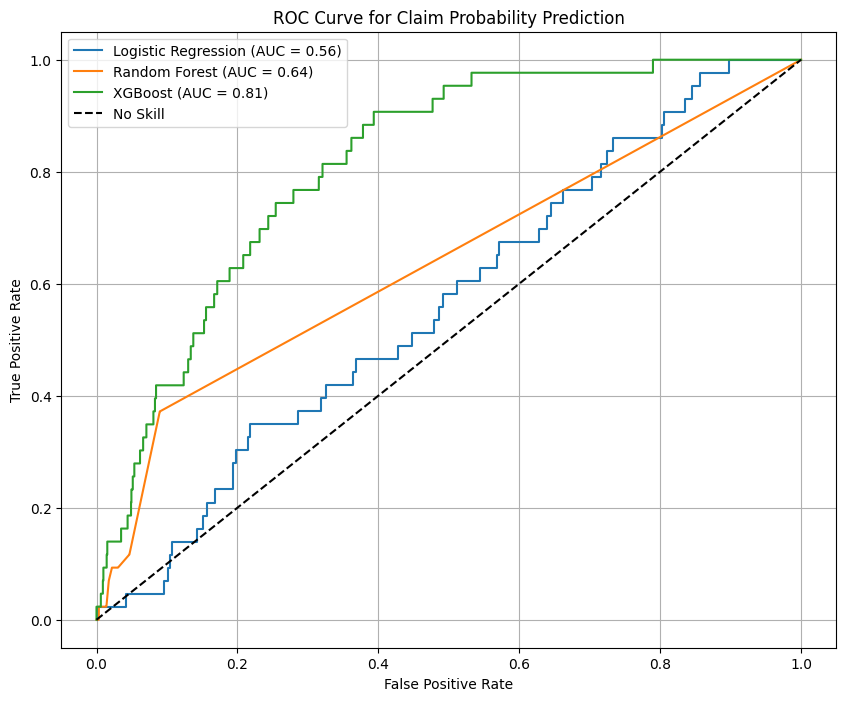

In [53]:
# Plotting ROC Curves (optional, but good for visualization)
plt.figure(figsize=(10, 8))
fpr_lr, tpr_lr, _ = roc_curve(y_test_prob, y_prob_lr_prob)
plt.plot(fpr_lr, tpr_lr, label=f'Logistic Regression (AUC = {roc_auc_lr_prob:.2f})')
fpr_rf, tpr_rf, _ = roc_curve(y_test_prob, y_prob_rf_prob)
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf_prob:.2f})')
fpr_xg, tpr_xg, _ = roc_curve(y_test_prob, y_prob_xg_prob)
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC = {roc_auc_xg_prob:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='No Skill')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Claim Probability Prediction')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
# For Random Forest or XGBoost (Regression or Classification)
# Example for Claim Severity Prediction (Random Forest)
if hasattr(rf_severity_model, 'feature_importances_'):
    feature_importances = pd.Series(rf_severity_model.feature_importances_, index=X_train_severity.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)
    print("\nRandom Forest Claim Severity - Feature Importances:")
    print(feature_importances_sorted.head(10)) # Top 10 features

# For Linear Regression (Coefficients)
if hasattr(lr_severity_model, 'coef_'):
    coefficients = pd.Series(lr_severity_model.coef_, index=X_train_severity.columns)
    coefficients_sorted = coefficients.abs().sort_values(ascending=False)
    print("\nLinear Regression Claim Severity - Absolute Coefficients:")
    print(coefficients_sorted.head(10)) # Top 10 features by absolute value


Random Forest Claim Severity - Feature Importances:
SumInsured                                                                       0.189843
ExcessSelected_Mobility - Taxi with value more than R100 000 - R5 000 (April)    0.170803
CapitalOutstanding                                                               0.161465
CoverType_Own Damage                                                             0.068689
AccountType_Unknown                                                              0.059702
TrackingDevice_Yes                                                               0.036366
PostalCode                                                                       0.026983
TransactionMonth_Month                                                           0.020729
kilowatts                                                                        0.017686
RegistrationYear                                                                 0.017677
dtype: float64

Linear Regression Claim Severit

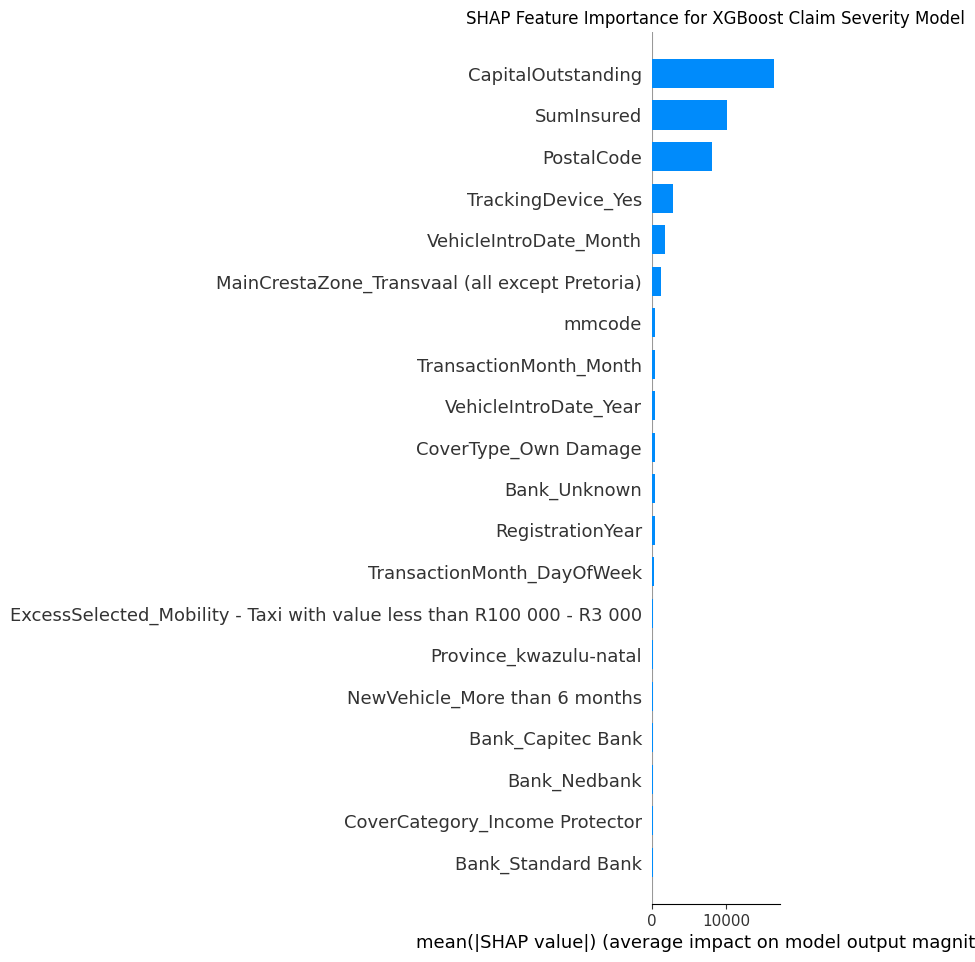

In [ ]:
# Example for XGBoost Claim Severity Model
explainer_xg_severity = shap.TreeExplainer(xg_severity_model)
shap_values_xg_severity = explainer_xg_severity.shap_values(X_test_severity)

# Summarize the feature importances (Mean absolute SHAP value)
shap.summary_plot(shap_values_xg_severity, X_test_severity, plot_type="bar", show=False)
plt.title("SHAP Feature Importance for XGBoost Claim Severity Model")
plt.show()

# Plot individual predictions (e.g., for the first test instance)
shap.initjs() # For interactive plots in notebooks
shap.force_plot(explainer_xg_severity.expected_value, shap_values_xg_severity[0,:], X_test_severity.iloc[0,:])